In [1]:
# importing necessary dependancies
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import import_ipynb
from models import LSTMNet, CustomNet
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time

importing Jupyter notebook from models.ipynb
importing Jupyter notebook from helpers.ipynb


In [2]:
# use NVIDIA Geforce GTX 1650
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# hyperparameters
batch_size = 500
input_size = 2
hidden_size = 200
num_classes = 1
learning_rate = 0.001
momentum = 0.8
use_nesterov = True
max_norm = 1.0
epochs = 1000

In [4]:
# function to create the adding problem dataset
def adding_problem_generator(N, seq_len=8, high=1):
    """ A data generator for adding problem.

    A single entry has a 2D vector with two rows of the same length. 
    The first row has random numbers, and the second row contains a 
    binary mask with ones at only two positions. The label for this 
    entry is the sum of the numbers from the first row where the mask 
    is one.

     input          label
     -----          -----
    1 4 5 3  ----->   9 (4 + 5)
    0 1 1 0

    N: the number of the entries.
    eq_len: the length of a single sequence.
    p: the probability of 1 in generated mask
    high: the random data is sampled from a [0, high] uniform distribution.
    return: (X, Y), X the data, Y the label.
    """
    X_num = np.random.uniform(low=0, high=high, size=(N, seq_len, 1))
    X_mask = np.zeros((N, seq_len, 1))
    Y = np.ones((N, 1))
    for i in range(N):
        # Default uniform distribution on position sampling
        positions = np.random.choice(seq_len, size=2, replace=False)
        X_mask[i, positions] = 1
        Y[i, 0] = np.sum(X_num[i, positions])
    X = np.append(X_num, X_mask, axis=2)
    return X, Y

In [5]:
# creating the train and test datasets
X_train, Y_train = adding_problem_generator(10000, 8, 1)
X_val, Y_val = adding_problem_generator(1000, 8, 1)
X_test, Y_test = adding_problem_generator(100, 8, 1)
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
X_val = torch.tensor(X_val).float()
Y_val = torch.tensor(Y_val).float()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

In [6]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([10000, 8, 2]) torch.Size([10000, 1])
torch.Size([1000, 8, 2]) torch.Size([1000, 1])
torch.Size([100, 8, 2]) torch.Size([100, 1])


In [7]:
class AddingProblemDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

train_dataset = AddingProblemDataset(X_train, Y_train)
val_dataset = AddingProblemDataset(X_val, Y_val)

In [8]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [9]:
lstmnet = LSTMNet(input_size, hidden_size, num_classes).to(device)
customnet= CustomNet(input_size, hidden_size, num_classes).to(device)

In [10]:
total_lstmnet_parameters = count_parameters(lstmnet)
total_customnet_parameters = count_parameters(customnet)

In [11]:
criterion = nn.MSELoss()
lstmnet_optimizer = torch.optim.Adam(lstmnet.parameters(), lr = learning_rate)
customnet_optimizer = torch.optim.Adam(customnet.parameters(), lr = learning_rate)

In [12]:
lstmnet_train_loss_array = []
lstmnet_val_loss_array = []
customnet_train_loss_array = []
customnet_val_loss_array = []

In [13]:
lstmnet_start_time = time.time()
train_and_validate(epochs, device, lstmnet, train_loader, val_loader, criterion, lstmnet_optimizer, lstmnet_train_loss_array, lstmnet_val_loss_array)
lstmnet_end_time = time.time()
lstmnet_total_training_time = lstmnet_end_time - lstmnet_start_time
lstmnet_avg_training_time_per_epoch = lstmnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 0.950812566280365 | Validation Loss: 0.7852314412593842
Epoch no.: 2 | Training Loss: 0.6979336500167846 | Validation Loss: 0.5251527428627014
Epoch no.: 3 | Training Loss: 0.4300342366099358 | Validation Loss: 0.29577139019966125
Epoch no.: 4 | Training Loss: 0.25160934403538704 | Validation Loss: 0.21825550496578217
Epoch no.: 5 | Training Loss: 0.20666711628437043 | Validation Loss: 0.20531725883483887
Epoch no.: 6 | Training Loss: 0.1925319768488407 | Validation Loss: 0.19248119741678238
Epoch no.: 7 | Training Loss: 0.18458851650357247 | Validation Loss: 0.18654171377420425
Epoch no.: 8 | Training Loss: 0.17990666553378104 | Validation Loss: 0.18326010555028915
Epoch no.: 9 | Training Loss: 0.17666902244091034 | Validation Loss: 0.18017339706420898
Epoch no.: 10 | Training Loss: 0.1739885538816452 | Validation Loss: 0.17734204232692719
Epoch no.: 11 | Training Loss: 0.17163077965378762 | Validation Loss: 0.17548594623804092
Epoch no.: 12 | Training Lo

In [14]:
customnet_start_time = time.time()
train_and_validate(epochs, device, customnet, train_loader, val_loader, criterion, customnet_optimizer, customnet_train_loss_array, customnet_val_loss_array)
customnet_end_time = time.time()
customnet_total_training_time = customnet_end_time - customnet_start_time
customnet_avg_training_time_per_epoch = customnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 1.0066179513931275 | Validation Loss: 0.7808671593666077
Epoch no.: 2 | Training Loss: 0.6652119815349579 | Validation Loss: 0.4862891882658005
Epoch no.: 3 | Training Loss: 0.4329068258404732 | Validation Loss: 0.36857470870018005
Epoch no.: 4 | Training Loss: 0.36015292108058927 | Validation Loss: 0.3357786536216736
Epoch no.: 5 | Training Loss: 0.3398709699511528 | Validation Loss: 0.32718729972839355
Epoch no.: 6 | Training Loss: 0.3332799419760704 | Validation Loss: 0.3218046873807907
Epoch no.: 7 | Training Loss: 0.32681248933076856 | Validation Loss: 0.31600454449653625
Epoch no.: 8 | Training Loss: 0.31986504793167114 | Validation Loss: 0.3088071644306183
Epoch no.: 9 | Training Loss: 0.312244339287281 | Validation Loss: 0.30168314278125763
Epoch no.: 10 | Training Loss: 0.30380313098430634 | Validation Loss: 0.2938801199197769
Epoch no.: 11 | Training Loss: 0.2949101984500885 | Validation Loss: 0.2853866219520569
Epoch no.: 12 | Training Loss: 0.2

In [15]:
lstmnet_predictions = lstmnet(X_test.to(device)).cpu().detach().numpy()
customnet_predictions = customnet(X_test.to(device)).cpu().detach().numpy()

In [16]:
# FINAL REPORT PRINT
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     LSTMNet: {total_lstmnet_parameters}  |  CustomNet: {total_customnet_parameters}")
print()
print(f"Total Training Time:     LSTMNet: {lstmnet_total_training_time}s  |  CustomNet: {customnet_total_training_time}s")
print()
print(f"Average Training Time Per Epoch:     LSTMNet: {lstmnet_avg_training_time_per_epoch}s  |  CustomNet: {customnet_avg_training_time_per_epoch}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     LSTMNet: 162601  |  CustomNet: 80801

Total Training Time:     LSTMNet: 494.6003839969635s  |  CustomNet: 346.00297117233276s

Average Training Time Per Epoch:     LSTMNet: 0.4946003839969635s  |  CustomNet: 0.34600297117233275s
------------------------------------------------------------


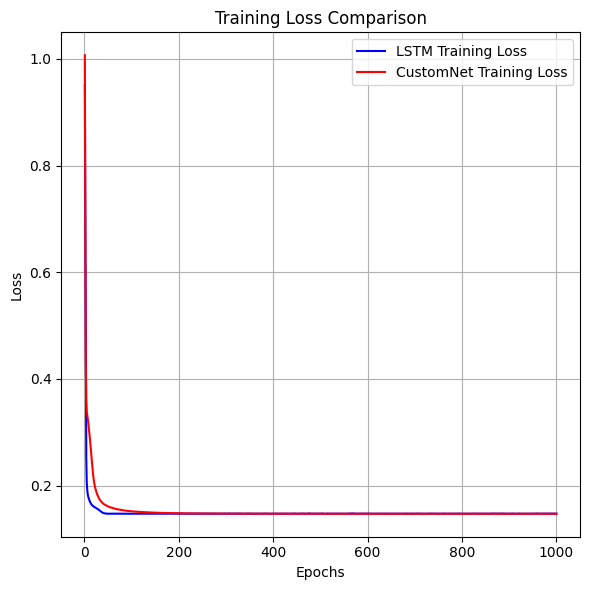

In [17]:
plot_loss_comparison(epochs, lstmnet_train_loss_array, customnet_train_loss_array, "LSTM Training Loss", "CustomNet Training Loss", "Training Loss Comparison")

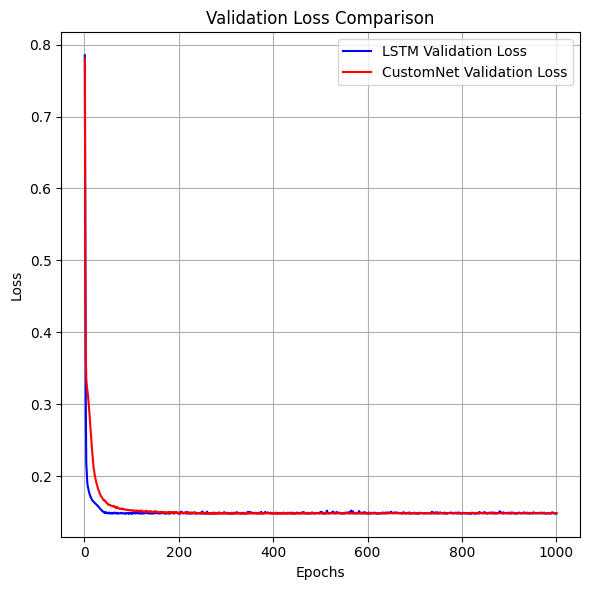

In [18]:
plot_loss_comparison(epochs, lstmnet_val_loss_array, customnet_val_loss_array, "LSTM Validation Loss", "CustomNet Validation Loss", "Validation Loss Comparison")

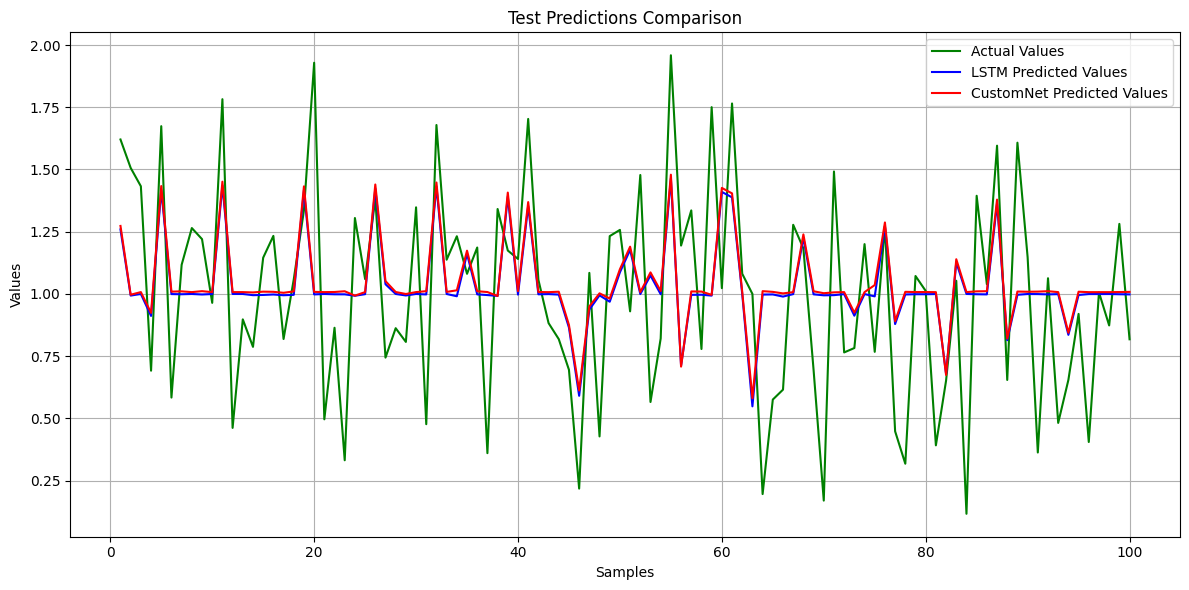

In [19]:
plot_test_predictions(Y_test, lstmnet_predictions, customnet_predictions)

In [20]:
compare_mse_loss(Y_test, lstmnet_predictions, customnet_predictions)

LSTM MSE Loss: 0.1351744532585144
Custom Network MSE Loss: 0.13620084524154663
